Добрый день!
В этом проекте я собираю данные о вакансиях с сайта hh.ru и решаю, куда же пойти работать
Приятного просмотра)

Часть 1. Получаем данные при помощи селениум!

In [130]:
!pip install streamlit

In [5]:
!pip install webdriver_manager
!pip install --upgrade selenium
!pip install selenium-wire
!pip install requests

Будем пользоваться браузером FireFox!
Причем искать будем только экономические вакансии (не зря же мы получаем диплом)
Для этого на самом сайте я выбрала поиск экономических должностей

In [131]:
import time
import re
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.firefox import GeckoDriverManager
import streamlit as st

In [158]:
driver = webdriver.Firefox()

In [159]:
driver.get("https://hh.ru/search/vacancy?L_save_area=true&order_by=publication_time&items_on_page=20&hhtmFrom=vacancy_search_filter&professional_role=16&professional_role=154&professional_role=18&professional_role=50&professional_role=158&professional_role=57&professional_role=155&professional_role=147&professional_role=134&professional_role=135&professional_role=136&professional_role=137&professional_role=142&search_field=name&search_field=company_name&search_field=description&text=&enable_snippets=false")

Как было замечено в процессе работы, селениум иногда ведет себя как истеричка и бросает начатое на полпути
Поэтому было решено использовать функцию
Мне помог https://stackoverflow.com/questions/37535860/selenium-python-web-driver-wait-locates-an-element-find-element-does-not

In [160]:
def patience():
    WebDriverWait(driver, 5).until(
        EC.presence_of_element_located((By.XPATH, 'a[data-qa="pager-next"]')))

Собираем данные: нам нужно название должности, зарплата, требуемый опыт, работодатель, а также город

In [172]:
# Инициализация списков для хранения данных
titles = []
salaries = []
experiences = []
employers = []
cities = []

while len(titles) < 5000:
    # Поиск всех карточек вакансий на странице
    spans = driver.find_elements(By.CLASS_NAME, "vacancy-card--H8LvOiOGPll0jZvYpxIF")
    
    # Проход по каждой карточке и извлечение данных
    for span in spans:
        b=span.text.split("\n")
        remote_possible="Можно удалённо" in b
        # Извлечение данных о должности
        try:
            title_element = span.find_element(By.CSS_SELECTOR, 'span[data-qa="serp-item__title"]')
            titles.append(title_element.text)
        except:
            titles.append("")

         # Извлечение данных о зарплате
        try:
            salary_element = span.find_element(By.CSS_SELECTOR, 'span.compensation-text--cCPBXayRjn5GuLFWhGTJ')
            salary_text = salary_element.text
            salaries.append(salary_text)
            salary_exists = True
        except:
            salaries.append("")
            salary_exists = False

        # Извлечение данных о требуемом опыте
        try:
            experience_element = span.find_element(By.CSS_SELECTOR, 'span[data-qa="vacancy-serp__vacancy-work-experience"]')
            experiences.append(experience_element.text)
        except:
            experiences.append("")

        # Извлечение данных о работодателе
        try:
            employer_element = span.find_element(By.CSS_SELECTOR, 'span.company-info-text--O32pGCRW0YDmp3BHuNOP')
            employers.append(employer_element.text)
        except:
            employers.append("")

         # Извлечение данных о городе
        #Нам известно. что город записан на 5 строке, если зарплата не пропущена, и на 4, если пропущена. Есть еще информация об удаленности работы
        #Поэтому запишем так
        try:
            span_lines = span.find_elements(By.TAG_NAME, 'span')
            if salary_exists:
                if remote_possible:
                    city_name = b[5]
                else:
                    city_name = b[4]
            else:
                if remote_possible:
                    city_name = b[4]
                else:
                    city_name = b[3]
                city_name = b[3]
            cities.append(city_name)
        except:
            cities.append("")

 # Попытка найти и нажать кнопку "дальше" для перехода на следующую страницу
    try:
        next_button = driver.find_element(By.CSS_SELECTOR, 'a[data-qa="pager-next"]')
        next_button.click()
        time.sleep(5)
    except:
        print("Нет кнопки 'дальше', завершение сбора данных.")
        break


# Создание датафрейма из собранных данных
df = pd.DataFrame({
    'Title': titles,
    'Salary': salaries,
    'Experience': experiences,
    'Employer': employers,
    'City': cities
})

# Сохранение датафрейма в CSV файл
df.to_csv('vacancies.csv', index=False)

print("Данные успешно сохранены в 'vacancies.csv'")

Нет кнопки 'дальше', завершение сбора данных.
Данные успешно сохранены в 'vacancies.csv'


Замечание: звезды сложились так, что проект мне пришлось делать в месте с не очень быстрым интернетом, поэтому мне важно было
дать браузеру успеть загрузиться, отсюда большие паузы. Если вам повезло больше чем мне, то для вас конечно эти паузы не оправданы
и у вас смысла в моем парсинге нет,
поэтому я сохранила все в файлик result)

Часть 2: Обработаем данные!
Во-первых, зарплаты указаны очень неоднородно: есть и цифры и слова, где-то налоги учтены, а где-то нет, где-то дан диапазон(
Поступим так: 
Если зарплаты вообще нет, то удалим такую строчку.
Если указан диапазон, то возьмем нижнюю его границу - вдруг работодатель жадный?
Если указано "до вычета налогов", то вычтем еще 13 процентов. Если указано "на руки", то так и оставим

Еще обработаем город: как видно, в каких-то случаях через точку указана станция метро, мы это учитывать не будем
(Например от Санкт-Петербург•Маяковская оставим только Санкт-Петербург)

Еще исключим строчки где зарплата не в рублях - зачем нам такое?

Заодно ипользуем регулярные выражения!

In [125]:
df=pd.read_csv('vacancies.csv')
df = df.dropna(subset=['Salary']) #Убрали все, где нет зарплаты
df = df.dropna(subset=['City']) #Убрали все, где нет города
def is_ruble(salary): #Функция, отвечающая за рубль. Хоть кто-то за него пусть отвечает
    return '₽' in salary
    

df = df[df['Salary'].apply(is_ruble)]

def clean_salary(salary): # Функция для обработки значений зарплаты
    salary = salary.replace(' ', '') # Уберем пробелы для простоты
    
    if '-' in salary: # Проверка, является ли строка диапазоном
        lower_bound = salary.split('-')[0] #Возьмем нижнюю границу диапазона
        
    elif 'до' in salary:
        lower_bound = re.findall(r'\d+', salary)[0]
        
    elif 'от' in salary:
        lower_bound = re.findall(r'\d+', salary)[0]
        
    else:
        # Если это не диапазон и не граница, берем все перед символом рубля
        lower_bound = salary.split('₽')[0]

    clean_number = re.findall(r'\d+', lower_bound)
    
    if clean_number:
        number = int(clean_number[0])
        
        # Проверка на наличие "до вычета налогов"
        if 'довычетаналогов' in salary:
            number = int(number * 0.87)
        
        return number
    return None

df['Salary'] = df['Salary'].apply(clean_salary)

def clean_city(city):
    return city.split('•')[0] #Оставляем только название города, все остальное не нужно

df['City'] = df['City'].apply(clean_city)

df

,Title,Salary,Experience,Employer,City
0,Оператор по продаже инвестиций,43,Без опыта,Т-Банк,Волгоград
1,Оператор по продаже инвестиций,43,Без опыта,Т-Банк,Ульяновск
2,Ведущий бухгалтер по расчету заработной платы,93,Опыт 1-3 года,"Теремок - Русские Блины, Санкт-Петербург",Санкт-Петербург
3,Менеджер выездного сервиса,53,Без опыта,Сбер для экспертов,Петрозаводск
4,Старший менеджер по работе с ключевыми клиента...,120,Опыт 1-3 года,Сбер для экспертов,Санкт-Петербург
...,...,...,...,...,...
2194,Инженер по организации и нормированию труда,47,Опыт 1-3 года,ООО Эл 6,Новочеркасск
2195,Помощник бухгалтера,65,Опыт 1-3 года,ООО Тактика +,Москва
2196,Бухгалтер по учету ТМЦ,53,Опыт 1-3 года,ООО ФауБеХа-Сиб,Омск
2198,Бухгалтер,55,Опыт 3-6 лет,Лабораторный медицинский продукт,Санкт-Петербург


Заметим еще, что очень много где встречаются слова "Менеджер" и "Бухгалтер" (экономисты, что с них взять)
Поэтому мы заменим эти должности кодовыми словами "Бухгалтер" и "Менеджер":

In [27]:
def clean_position(position):
    position_lower = position.lower() #приведем все к нижнему регистру чтобы в любом случае поймать кодовое слово
    
    if 'бухгалтер' in position_lower:
        return 'Бухгалтер'
    elif 'менеджер' in position_lower:
        return 'Менеджер'
    
    position = position.strip()
    
    return position

df['Title'] = df['Title'].apply(clean_position)
df

,Title,Salary,Experience,Employer,City
0,Оператор по продаже инвестиций,43,Без опыта,Т-Банк,Волгоград
1,Оператор по продаже инвестиций,43,Без опыта,Т-Банк,Ульяновск
2,Бухгалтер,93,Опыт 1-3 года,"Теремок - Русские Блины, Санкт-Петербург",Санкт-Петербург
3,Менеджер,53,Без опыта,Сбер для экспертов,Петрозаводск
4,Менеджер,120,Опыт 1-3 года,Сбер для экспертов,Санкт-Петербург
...,...,...,...,...,...
2194,Инженер по организации и нормированию труда,47,Опыт 1-3 года,ООО Эл 6,Новочеркасск
2195,Бухгалтер,65,Опыт 1-3 года,ООО Тактика +,Москва
2196,Бухгалтер,53,Опыт 1-3 года,ООО ФауБеХа-Сиб,Омск
2198,Бухгалтер,55,Опыт 3-6 лет,Лабораторный медицинский продукт,Санкт-Петербург


Часть 3: собственно анализируем что получилось!

Первая гипотеза, которую мы хотим проверить - зарплата выше, если опыта больше. Покажем, что это так и есть:

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0)]) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


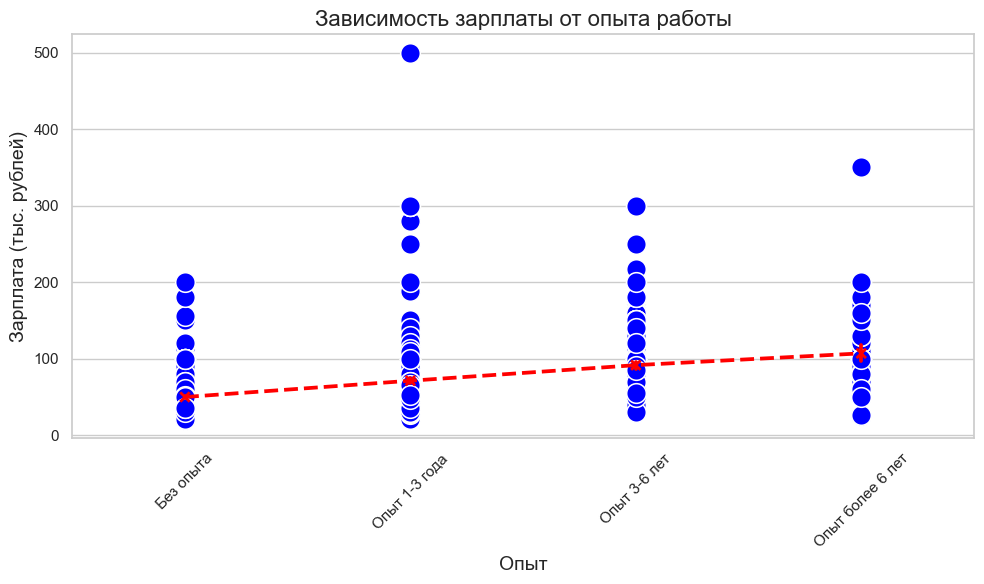

In [29]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.scatterplot(data=df, x='Experience', y='Salary', s=200, color='blue') #Строим точечный график

sns.pointplot(data=df, x='Experience', y='Salary', color='red', markers='x', linestyles='--') # Добавим еще средние значения

# Сделаем все по красоте
plt.xlabel('Опыт', fontsize=14)
plt.ylabel('Зарплата (тыс. рублей)', fontsize=14)
plt.title('Зависимость зарплаты от опыта работы', fontsize=16)

plt.xticks(rotation=45)  # Поворот подписей оси X
plt.tight_layout()  # Улучшение компактности графика
plt.show()

Зависимость конечно есть, красная линия средних значений имеет наклон. Но этот наклон очень небольшой, 
и все же мною ожидалась гораздо более ощутимая разница.
Наибольшая зарплата вообще наблюдается у работников с опытом менее 3 лет, да и в целом они получают больше чем те, у кого более 6 лет опыта
Объяснила бы я это тем, что все-таки самые крупные компании набирают на топовые позиции скорее всего не на хх(

Немного трансформируем таблицу: добавим к ней столбец с медианной зарплатой по городу: (мы тут применяем группировку и трансформацию)

In [53]:
df['Median_city'] = df.groupby('City')['Salary'].transform('median')
df

,Title,Salary,Experience,Employer,City,Median_city
0,Оператор по продаже инвестиций,43,Без опыта,Т-Банк,Волгоград,44.0
1,Оператор по продаже инвестиций,43,Без опыта,Т-Банк,Ульяновск,41.5
2,Бухгалтер,93,Опыт 1-3 года,"Теремок - Русские Блины, Санкт-Петербург",Санкт-Петербург,75.0
3,Менеджер,53,Без опыта,Сбер для экспертов,Петрозаводск,60.0
4,Менеджер,120,Опыт 1-3 года,Сбер для экспертов,Санкт-Петербург,75.0
...,...,...,...,...,...,...
2194,Инженер по организации и нормированию труда,47,Опыт 1-3 года,ООО Эл 6,Новочеркасск,48.5
2195,Бухгалтер,65,Опыт 1-3 года,ООО Тактика +,Москва,90.0
2196,Бухгалтер,53,Опыт 1-3 года,ООО ФауБеХа-Сиб,Омск,57.0
2198,Бухгалтер,55,Опыт 3-6 лет,Лабораторный медицинский продукт,Санкт-Петербург,75.0


Теперь мы хотим оценить риски и шансы: насколько далеко при работе в каждом городе мы можем отклониться от медианы?
Для этого применим оконную функцию и построим график. Будем смотреть, как минимум и максимум для каждого города далеки от медианы

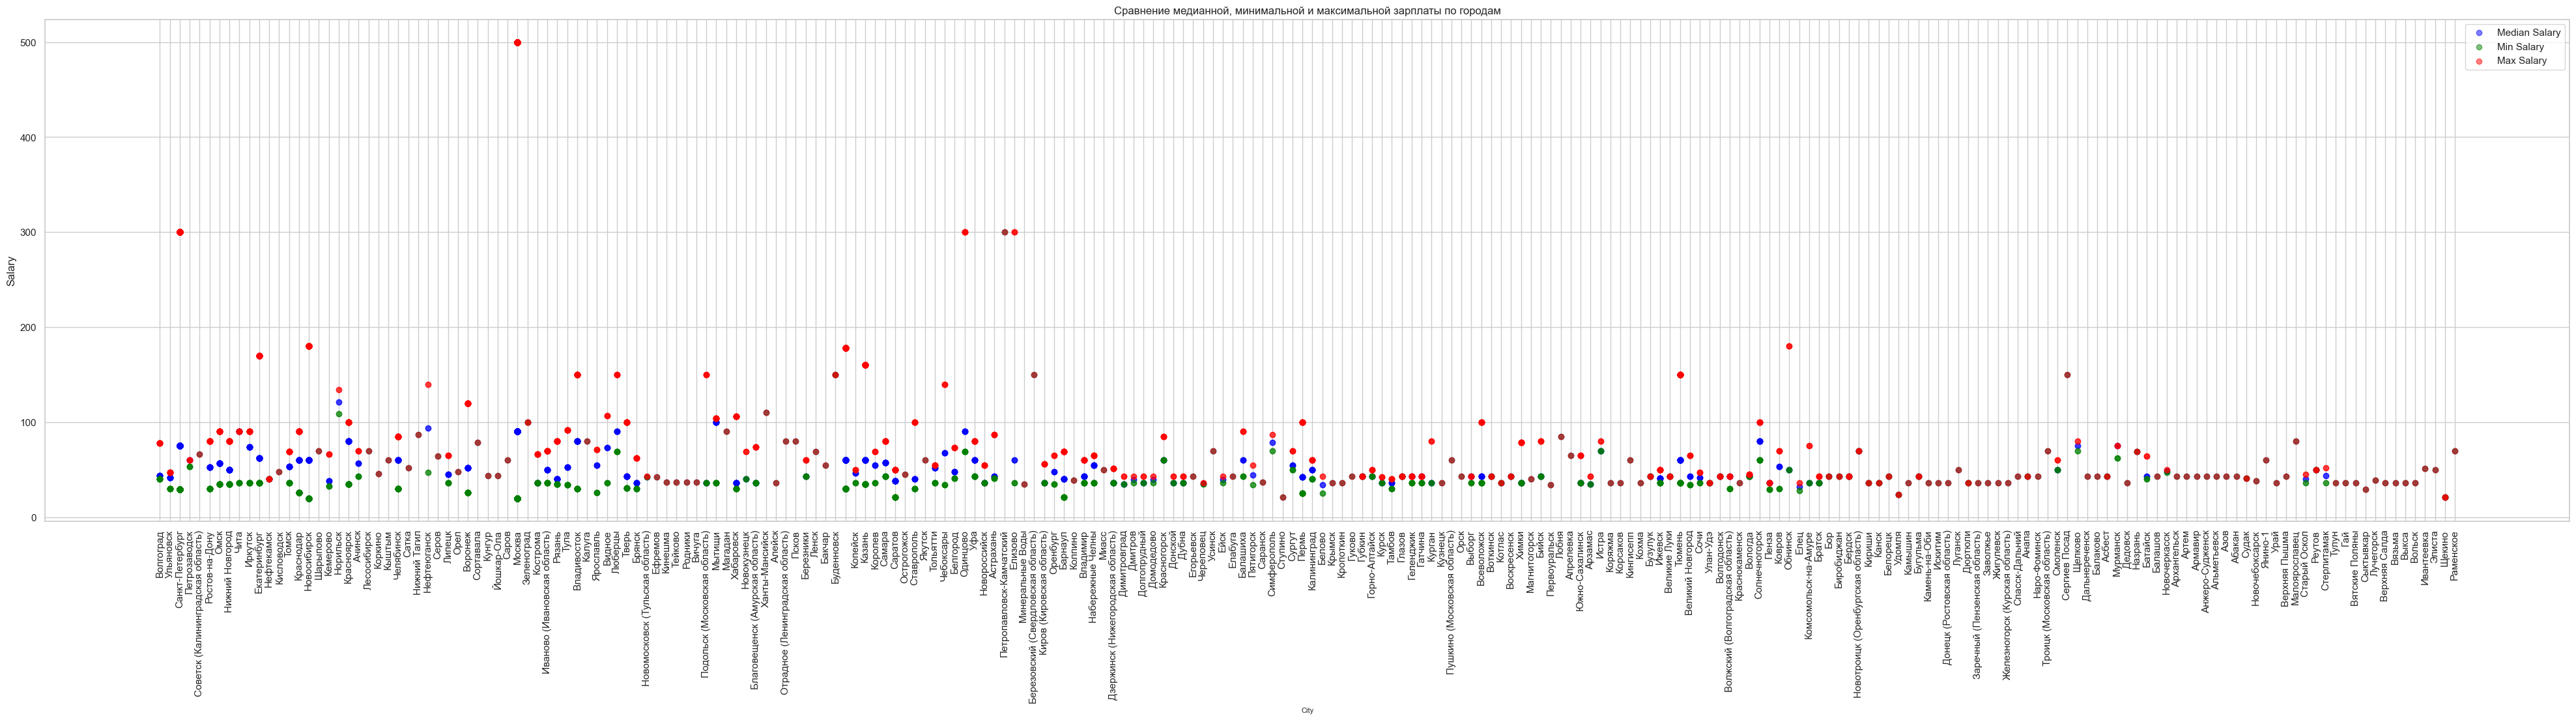

In [66]:
df['Min_Salary'] = df.groupby('City')['Salary'].transform('min')
df['Max_Salary'] = df.groupby('City')['Salary'].transform('max')

# Вычисляем процентное отклонение:
df['Min_Deviation'] = (df['Min_Salary'] - df['Median_city']) / df['Median_city'] * 100
df['Max_Deviation'] = (df['Max_Salary'] - df['Median_city']) / df['Median_city'] * 100
df
plt.figure(figsize=(50, 10))
plt.scatter(df['City'], df['Median_city'], label='Median Salary', color='blue', alpha=0.5)
plt.scatter(df['City'], df['Min_Salary'], label='Min Salary', color='green', alpha=0.5)
plt.scatter(df['City'], df['Max_Salary'], label='Max Salary', color='red', alpha=0.5)
plt.xlabel('City', fontsize=8)
plt.ylabel('Salary')
plt.title('Сравнение медианной, минимальной и максимальной зарплаты по городам')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Как и ожидалось, самые высокие отклонения вверх мы видим в самых крупных городах. 
А по поводу сильно низкой (относительно медианы, конечно)))зарплаты, к счастью, сильно переживать не придется. 
Как правило, самая низкая зарплата не сильно ниже медианной, поэтому прям большого отрыва вниз от медианных ожиданий мы не получим

Часть 4: Машинное обучение
Попробуем предсказать, на какую зарплату могут рассчитывать люди исходя из опыта и города. Чтобы избежать неточностей,
возьмем должность, которая шире всего представлена в таблице - Бухгалтер
Заодно используем "математические возможности Питона"

Важно пояснить: мы оставим только те города, которые встречаются у бухгалтеров хотя бы дважды (иначе как научить и протестировать?)
Потом отсортируем новый датафрейм по городам, а когда будем набирать тестовые и обучающие данные, то пойдем построчно:
нечетные строчки пойдут для обучения, а четные - для теста.

In [96]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# оставляем только вакансии с должностью "Бухгалтер"
df_buhgalter = df[df['Title'] == 'Бухгалтер']

#Оставим то, на чем будем учить
city_experience_counts = df_buhgalter.groupby(['City', 'Experience']).size().reset_index(name='count')
cities_to_remove = city_experience_counts[city_experience_counts['count'] == 1]['City'].unique()
df_buhgalter = df_buhgalter[~df_buhgalter['City'].isin(cities_to_remove)]

# Сортируем датафрейма по городам
df_buhgalter = df_buhgalter.sort_values(by='City')
df_buhgalter




,Title,Salary,Experience,Employer,City,Median_city,Min_Salary,Max_Salary,Min_Deviation,Max_Deviation
728,Бухгалтер,35,Опыт 1-3 года,Группа компаний АФГ Националь,Арзамас,35.0,35,43,0.000000,22.857143
760,Бухгалтер,35,Опыт 1-3 года,Группа компаний АФГ Националь,Арзамас,35.0,35,43,0.000000,22.857143
708,Бухгалтер,80,Опыт 3-6 лет,ООО Бийский завод котлов и вспомогательного об...,Бийск,43.0,43,80,0.000000,86.046512
702,Бухгалтер,80,Опыт 3-6 лет,ООО Бийский завод котлов и вспомогательного об...,Бийск,43.0,43,80,0.000000,86.046512
1225,Бухгалтер,30,Опыт 1-3 года,ОАО Брянский гормолзавод,Брянск,36.5,30,62,-17.808219,69.863014
...,...,...,...,...,...,...,...,...,...,...
2180,Бухгалтер,21,Без опыта,ГУ ТО ЦЗН ТО г. Щекино,Щекино,21.0,21,21,0.000000,0.000000
2001,Бухгалтер,70,Опыт 1-3 года,Конгресс-отель Ареал,Щелково,75.0,70,80,-6.666667,6.666667
1531,Бухгалтер,80,Опыт 1-3 года,ООО Фабрика надежных проектов,Щелково,75.0,70,80,-6.666667,6.666667
1701,Бухгалтер,65,Опыт 1-3 года,Гриль Хаус,Южно-Сахалинск,36.0,36,65,0.000000,80.555556


In [97]:
!pip install catboost

In [95]:
from catboost import CatBoostRegressor

# Создаем списки индексов для обучающего и тестового наборов данных
train_indices = [i for i in range(len(df_buhgalter)) if i % 2 == 0]
test_indices = [i for i in range(len(df_buhgalter)) if i % 2 != 0]

# Выделим признаки и цели:
X = df_buhgalter[['City', 'Experience']]
y = df_buhgalter['Salary']

# Поделим данные на обучающие и тестовые:
X_train = X.iloc[train_indices]
X_test = X.iloc[test_indices]
y_train = y.iloc[train_indices]
y_test = y.iloc[test_indices]

# Создадим и обучим модель CatBoost
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', random_state=42)
model.fit(X_train, y_train, cat_features=['City', 'Experience'], eval_set=(X_test, y_test), verbose=False)

# Предскажем:
y_pred = model.predict(X_test)

# А теперь оценим:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R^2):", r2)


Mean Squared Error (MSE): 599.3907048965051
R-squared (R^2): 0.4635224715987627


Модель не самая точная, но примерно мы сможем оценить, чего ожидать, если захотим переехать и стать бухгалтером))

Часть 5. А где работать-то?
Для начала запишем себе список вакансий, где нас устроит зарплата. Чтобы сильно не наглеть, установим границу 100:
Будем использовать SQL!

In [98]:
!pip install pandasql

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26798 sha256=8dff8ff049af1b121e4e5910cf3e2c296ffbb427b25cb0fd350e3fdd9f692ca9
  Stored in directory: c:\users\dorfm\appdata\local\pip\cache\wheels\68\5d\a5\edc271b998f909801d7956959f699b976cc9896075dc47c153
Successfully built pandasql


In [101]:
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())
query = """
    SELECT *
    FROM df
    WHERE Salary > 100
"""
high_salary_vacancies = pysqldf(query)

print("Вакансии с высокой зарплатой:", high_salary_vacancies)

Вакансии с высокой зарплатой:                                                  Title  Salary     Experience  \
0                                             Менеджер     120  Опыт 1-3 года   
1    Ведущий специалист судебного и исполнительного...     134  Опыт 1-3 года   
2                                             Менеджер     140  Опыт 1-3 года   
3                                             Менеджер     107  Опыт 1-3 года   
4                                             Менеджер     150  Опыт 1-3 года   
..                                                 ...     ...            ...   
188                                          Бухгалтер     120  Опыт 1-3 года   
189                                           Менеджер     200      Без опыта   
190                     Ведущий специалист по финансам     113  Опыт 1-3 года   
191                                          Бухгалтер     109  Опыт 1-3 года   
192                                           Менеджер     121   Опыт 3-6 лет  

Опять бухгалтеры и менеджеры... Ладно!

Про зарплату бухгалтеров мы уже поговорили. Посмотрим на менеджеров и построим ящик с усами:

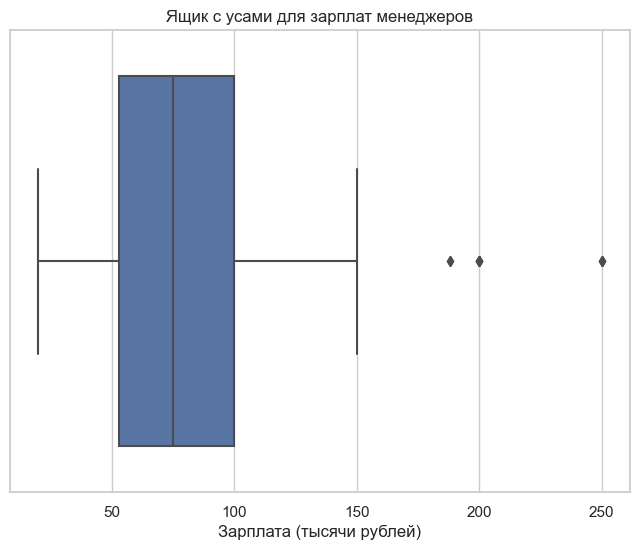

In [111]:
# Фильтруем данные по должности "Менеджер"
salary_manager = df[df['Title'] == 'Менеджер']['Salary']

plt.figure(figsize=(8, 6))
sns.boxplot(x=salary_manager)
plt.title('Ящик с усами для зарплат менеджеров')
plt.xlabel('Зарплата (тысячи рублей)')
plt.show()


собственно видим, что сильно много менеджеры не зарабатывают(
Посмотрим тогда на самые оплачиваемые профессии:

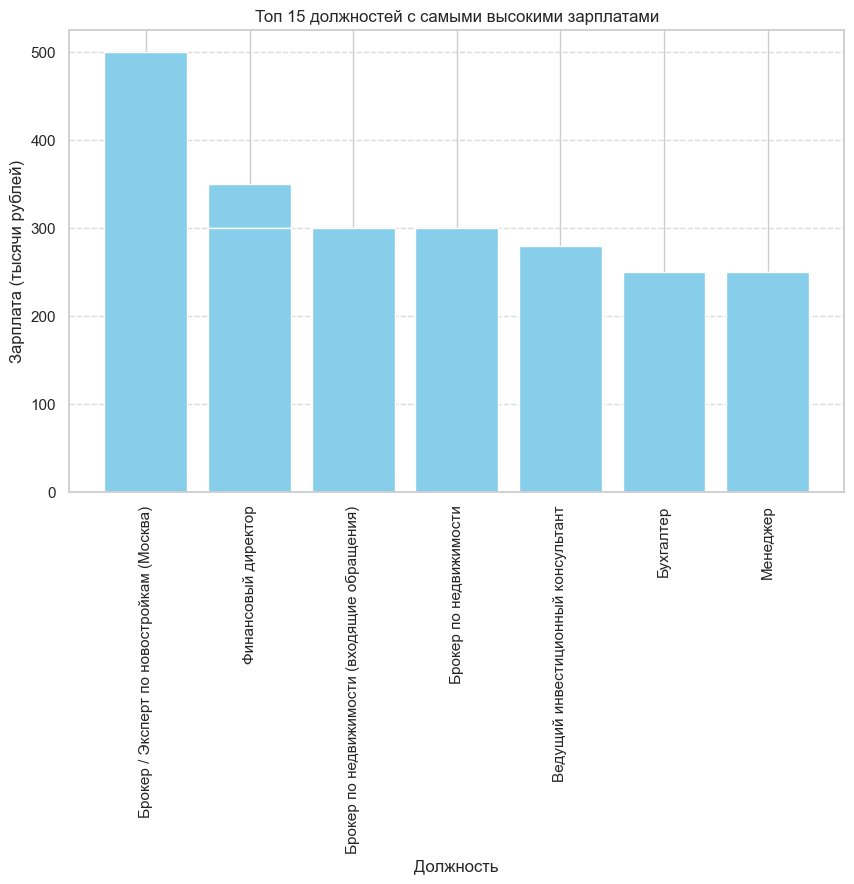

In [114]:
# Сортируем данные по зарплатам
sorted_salaries = df.sort_values(by='Salary', ascending=False)

# Выбираем верхние 15 должностей с самыми высокими зарплатами
top_15_positions = sorted_salaries.head(15)

plt.figure(figsize=(10, 6))
plt.bar(top_15_positions['Title'], top_15_positions['Salary'], color='skyblue')
plt.title('Топ 15 должностей с самыми высокими зарплатами')
plt.xlabel('Должность')
plt.ylabel('Зарплата (тысячи рублей)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Бухгалтеры и менеджеры и тут есть. Но лучше всего идти в финансы и инвестиции (что и ожидалось)

Предположим теперь, что у нас уже есть какая-то специализация.
И вдруг мы захотели переехать. А будет ли в городе переезда та же работа, что была у нас?
Выберем 20 городов с наибольшим количеством должностей. Если в двух городах есть одна и та же должность, то между ними есть связь
Причем чем больше совпадений, тем крепче связь

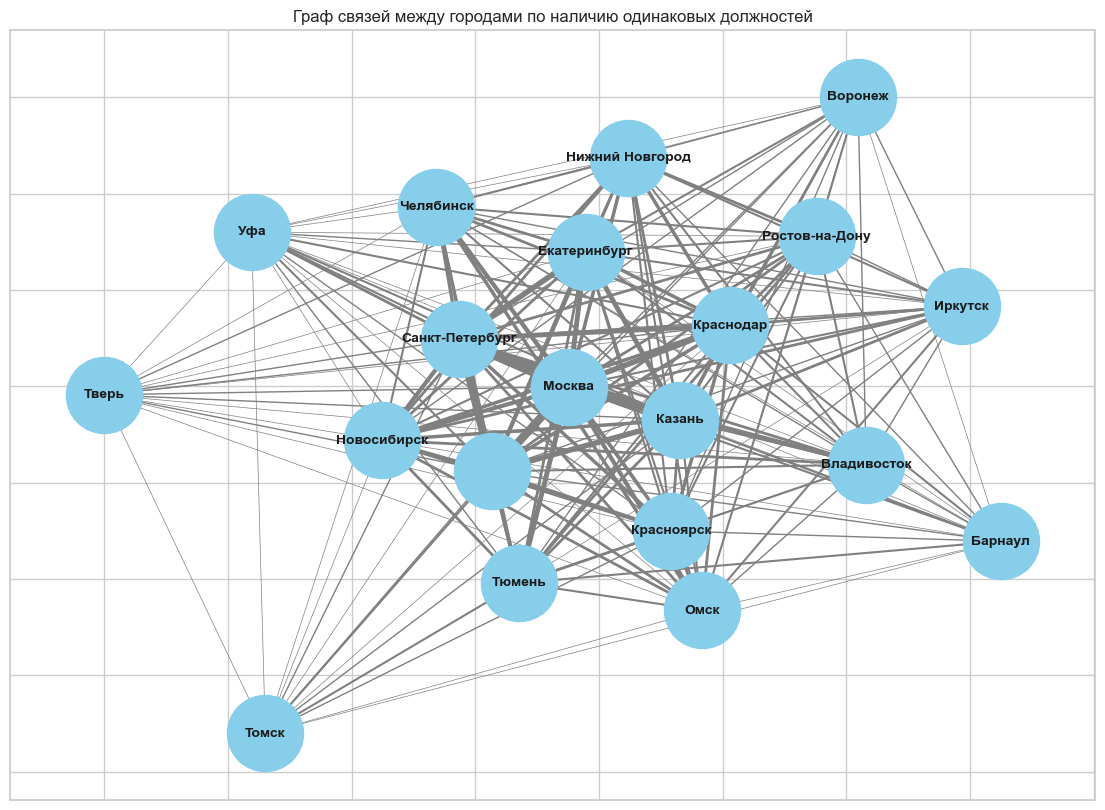

In [126]:
import networkx as nx

# Находим 20 городов с наибольшим количеством различных должностей
city_positions = df.groupby('City')['Title'].nunique().sort_values(ascending=False).head(20)

# Создаем граф
G = nx.Graph()

# Добавляем узлы для городов
for city in city_positions.index:
    G.add_node(city)

# Добавляем ребра между городами, если одна и та же должность встречается в обоих городах
for city1 in city_positions.index:
    for city2 in city_positions.index:
        if city1 != city2:
            positions1 = set(df[df['City'] == city1]['Title'])
            positions2 = set(df[df['City'] == city2]['Title'])
            common_positions = positions1 & positions2
            if common_positions:
                G.add_edge(city1, city2, weight=len(common_positions))

# Визуализируем граф
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.3)  # Расположение узлов

# Отрисовка узлов
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='skyblue')

# Отрисовка ребер с толщиной, зависящей от веса ребра
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[w * 0.5 for w in weights], edge_color='gray')

# Отрисовка меток
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title('Граф связей между городами по наличию одинаковых должностей')
plt.show()


Как и ожидалось, между крупными городами много совпадений.
Убеждена, менеджерам и бухгалтерам везде рады

Наконец, выберем лучшего работодателя. Построим график, который покажет нам связь между работодателем,
количеством должностей и размером зарплаты. Рассматривать будем крупные компании, у которых хотя бы 3 вакансии
Так мы избежим случайностей и неточностей:

Text(0.5, 1.0, 'Связь между работодателем, количеством должностей и зарплатой')

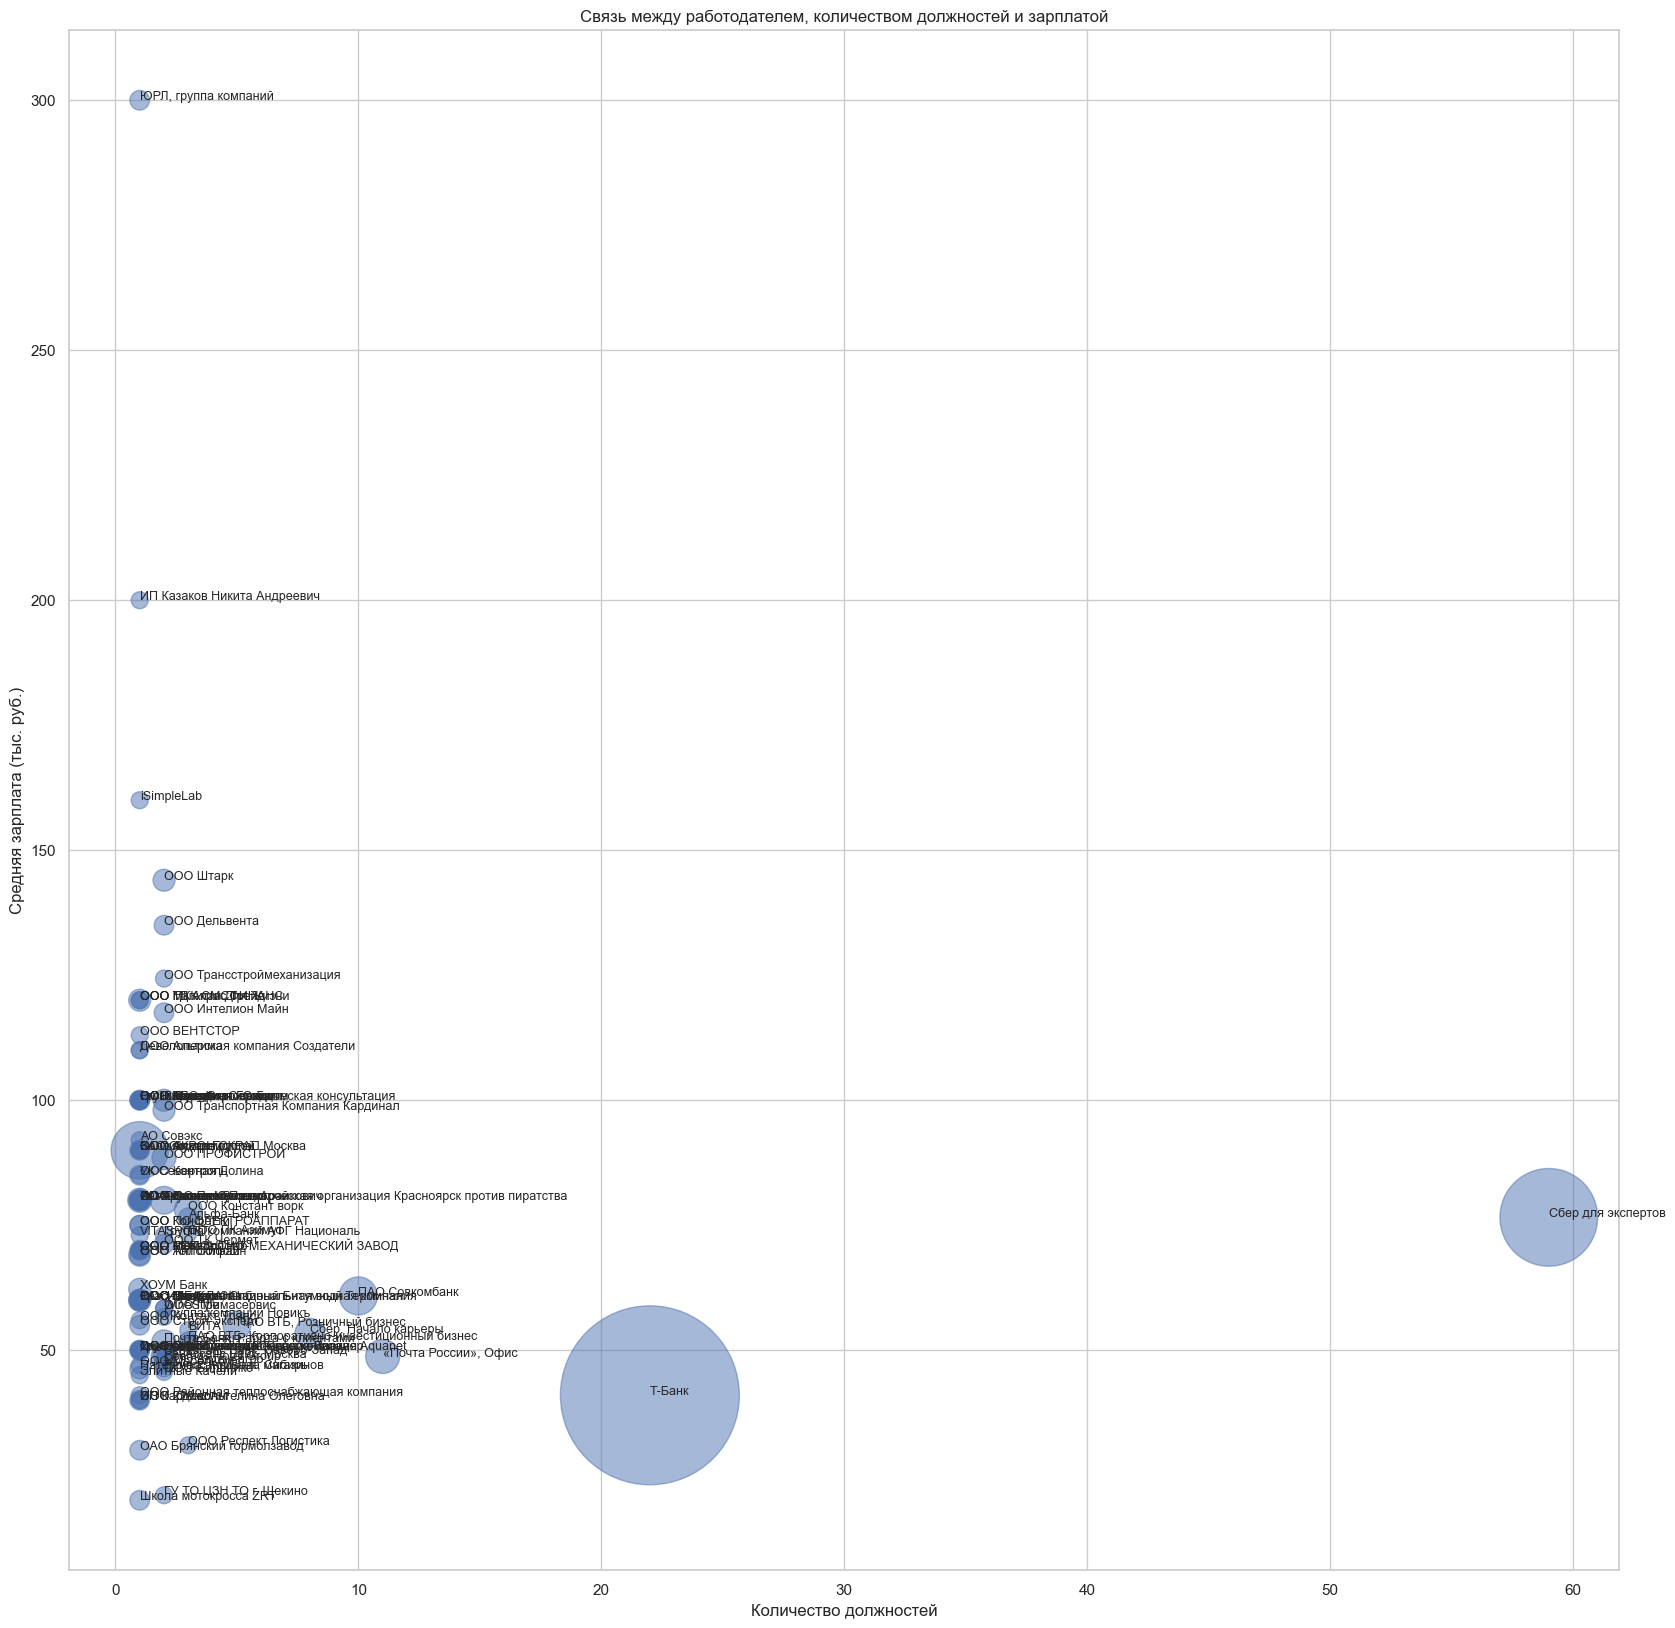

In [129]:
employer_stats = df.groupby('Employer').agg(
    num_positions=('Title', 'nunique'),
    avg_salary=('Salary', 'mean'),
    num_vacancies=('Title', 'count')
)
employer_stats = employer_stats[employer_stats['num_vacancies'] >= 3].reset_index()

# Строим пузырьковый график
plt.figure(figsize=(20, 20))
scatter = plt.scatter(
    x=employer_stats['num_positions'], 
    y=employer_stats['avg_salary'], 
    s=employer_stats['num_vacancies'] * 50,  # размер пузырьков
    alpha=0.5
)


for i, row in employer_stats.iterrows():
    plt.text(row['num_positions'], row['avg_salary'], row['Employer'], fontsize=9)

plt.xlabel('Количество должностей')
plt.ylabel('Средняя зарплата (тыс. руб.)')
plt.title('Связь между работодателем, количеством должностей и зарплатой')

Этот результат тоже был, пожалуй, более чем ожидаем. больше всего вакансий у Т-банка и Сбера, а зарплаты выще там, где конкуренция выше

Выводы:
Отбираться все же не через хэд хантер, потому что отбор на самые топовые вакансии все же проходит в рамках компании

В крупных компаниях больше должностей, но хх как правило предлагает те, на которых нужно мало опыта, а зарплаты ниже

Зависимость между опытом и зарплатой есть, но совершенно не критичная и не определяющая. 

Чем крупнее город, тем больше там популярных должностей и пересечений с другими городами

Но самый главный вывод, который графикам не поддается, - работа должна быть в удовольствие, чего и вам и себе желаю